In [1]:
from stable_baselines import logger, deepq
from stable_baselines.common import tf_util, OffPolicyRLModel, SetVerbosity, TensorboardWriter
from stable_baselines.common.vec_env import VecEnv
from stable_baselines.common.schedules import LinearSchedule
from stable_baselines.deepq.replay_buffer import ReplayBuffer, PrioritizedReplayBuffer
from stable_baselines.deepq.policies import DQNPolicy
from stable_baselines.a2c.utils import find_trainable_variables, total_episode_reward_logger
from functools import partial
import tensorflow as tf
import numpy as np
import gym
from stable_baselines.common.policies import MlpPolicy, CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt
from stable_baselines.deepq.policies import FeedForwardPolicy, CnnPolicy
from stable_baselines.common.cmd_util import make_atari_env, make_atari
from stable_baselines.common.vec_env import VecFrameStack
from stable_baselines.common.atari_wrappers import make_atari, MaxAndSkipEnv, NoopResetEnv
from stable_baselines.deepq import DQN, wrap_atari_dqn#, DQN2
from stable_baselines.bench import Monitor

/Users/phaniram/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [7]:
class DQN(OffPolicyRLModel):
    """
    The DQN model class. DQN paper: https://arxiv.org/pdf/1312.5602.pdf
    :param policy: (DQNPolicy or str) The policy model to use (MlpPolicy, CnnPolicy, LnMlpPolicy, ...)
    :param env: (Gym environment or str) The environment to learn from (if registered in Gym, can be str)
    :param gamma: (float) discount factor
    :param learning_rate: (float) learning rate for adam optimizer
    :param buffer_size: (int) size of the replay buffer
    :param exploration_fraction: (float) fraction of entire training period over which the exploration rate is
            annealed
    :param exploration_final_eps: (float) final value of random action probability
    :param train_freq: (int) update the model every `train_freq` steps. set to None to disable printing
    :param batch_size: (int) size of a batched sampled from replay buffer for training
    :param checkpoint_freq: (int) how often to save the model. This is so that the best version is restored at the
            end of the training. If you do not wish to restore the best version
            at the end of the training set this variable to None.
    :param checkpoint_path: (str) replacement path used if you need to log to somewhere else than a temporary
            directory.
    :param learning_starts: (int) how many steps of the model to collect transitions for before learning starts
    :param target_network_update_freq: (int) update the target network every `target_network_update_freq` steps.
    :param prioritized_replay: (bool) if True prioritized replay buffer will be used.
    :param prioritized_replay_alpha: (float)alpha parameter for prioritized replay buffer.
        It determines how much prioritization is used, with alpha=0 corresponding to the uniform case.
    :param prioritized_replay_beta0: (float) initial value of beta for prioritized replay buffer
    :param prioritized_replay_beta_iters: (int) number of iterations over which beta will be annealed from initial
            value to 1.0. If set to None equals to max_timesteps.
    :param prioritized_replay_eps: (float) epsilon to add to the TD errors when updating priorities.
    :param param_noise: (bool) Whether or not to apply noise to the parameters of the policy.
    :param verbose: (int) the verbosity level: 0 none, 1 training information, 2 tensorflow debug
    :param tensorboard_log: (str) the log location for tensorboard (if None, no logging)
    :param _init_setup_model: (bool) Whether or not to build the network at the creation of the instance
    :param full_tensorboard_log: (bool) enable additional logging when using tensorboard
        WARNING: this logging can take a lot of space quickly
    """

    def __init__(self, policy, env, gamma=0.99, learning_rate=5e-4, buffer_size=50000, exploration_fraction=0.1,
                 exploration_final_eps=0.02, train_freq=1, batch_size=32, checkpoint_freq=10000, checkpoint_path=None,
                 learning_starts=1000, target_network_update_freq=500, prioritized_replay=False,
                 prioritized_replay_alpha=0.6, prioritized_replay_beta0=0.4, prioritized_replay_beta_iters=None,
                 prioritized_replay_eps=1e-6, param_noise=False, verbose=0, tensorboard_log=None,
                 _init_setup_model=True, policy_kwargs=None, full_tensorboard_log=False):

        # TODO: replay_buffer refactoring
        super(DQN, self).__init__(policy=policy, env=env, replay_buffer=None, verbose=verbose, policy_base=DQNPolicy,
                                  requires_vec_env=False, policy_kwargs=policy_kwargs)

        self.checkpoint_path = checkpoint_path
        self.param_noise = param_noise
        self.learning_starts = learning_starts
        self.train_freq = train_freq
        self.prioritized_replay = prioritized_replay
        self.prioritized_replay_eps = prioritized_replay_eps
        self.batch_size = batch_size
        self.target_network_update_freq = target_network_update_freq
        self.checkpoint_freq = checkpoint_freq
        self.prioritized_replay_alpha = prioritized_replay_alpha
        self.prioritized_replay_beta0 = prioritized_replay_beta0
        self.prioritized_replay_beta_iters = prioritized_replay_beta_iters
        self.exploration_final_eps = exploration_final_eps
        self.exploration_fraction = exploration_fraction
        self.buffer_size = buffer_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tensorboard_log = tensorboard_log
        self.full_tensorboard_log = full_tensorboard_log

        self.graph = None
        self.sess = None
        self._train_step = None
        self.step_model = None
        self.update_target = None
        self.act = None
        self.proba_step = None
        self.replay_buffer = None
        self.beta_schedule = None
        self.exploration = None
        self.params = None
        self.summary = None
        self.episode_reward = None

        if _init_setup_model:
            self.setup_model()

    def _get_pretrain_placeholders(self):
        policy = self.step_model
        return policy.obs_ph, tf.placeholder(tf.int32, [None]), policy.q_values

    def setup_model(self):

        with SetVerbosity(self.verbose):
            assert not isinstance(self.action_space, gym.spaces.Box), \
                "Error: DQN cannot output a gym.spaces.Box action space."

            # If the policy is wrap in functool.partial (e.g. to disable dueling)
            # unwrap it to check the class type
            if isinstance(self.policy, partial):
                test_policy = self.policy.func
            else:
                test_policy = self.policy
            assert issubclass(test_policy, DQNPolicy), "Error: the input policy for the DQN model must be " \
                                                       "an instance of DQNPolicy."

            self.graph = tf.Graph()
            with self.graph.as_default():
                self.sess = tf_util.make_session(graph=self.graph)

                optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)

                self.act, self._train_step, self.update_target, self.step_model = deepq.build_train(
                    q_func=partial(self.policy, **self.policy_kwargs),
                    ob_space=self.observation_space,
                    ac_space=self.action_space,
                    optimizer=optimizer,
                    gamma=self.gamma,
                    grad_norm_clipping=10,
                    param_noise=self.param_noise,
                    sess=self.sess,
                    full_tensorboard_log=self.full_tensorboard_log
                )
                self.proba_step = self.step_model.proba_step
                self.params = find_trainable_variables("deepq")

                # Initialize the parameters and copy them to the target network.
                tf_util.initialize(self.sess)
                self.update_target(sess=self.sess)

                self.summary = tf.summary.merge_all()

    def learn(self, total_timesteps, callback=None, seed=None, log_interval=100, tb_log_name="DQN",
              reset_num_timesteps=True):

        new_tb_log = self._init_num_timesteps(reset_num_timesteps)

        with SetVerbosity(self.verbose), TensorboardWriter(self.graph, self.tensorboard_log, tb_log_name, new_tb_log) \
                as writer:
            self._setup_learn(seed)

            # Create the replay buffer
            if self.prioritized_replay:
                self.replay_buffer = PrioritizedReplayBuffer(self.buffer_size, alpha=self.prioritized_replay_alpha)
                if self.prioritized_replay_beta_iters is None:
                    prioritized_replay_beta_iters = total_timesteps
                else:
                    prioritized_replay_beta_iters = self.prioritized_replay_beta_iters
                self.beta_schedule = LinearSchedule(prioritized_replay_beta_iters,
                                                    initial_p=self.prioritized_replay_beta0,
                                                    final_p=1.0)
            else:
                self.replay_buffer = ReplayBuffer(self.buffer_size)
                self.beta_schedule = None
            # Create the schedule for exploration starting from 1.
            self.exploration = LinearSchedule(schedule_timesteps=int(self.exploration_fraction * total_timesteps),
                                              initial_p=1.0,
                                              final_p=self.exploration_final_eps)

            episode_rewards = [0.0]
            obs = self.env.reset()
            reset = True
            self.episode_reward = np.zeros((1,))

            for _ in range(total_timesteps):
                if callback is not None:
                    # Only stop training if return value is False, not when it is None. This is for backwards
                    # compatibility with callbacks that have no return statement.
                    if callback(locals(), globals()) is False:
                        break
                # Take action and update exploration to the newest value
                kwargs = {}
                if not self.param_noise:
                    update_eps = self.exploration.value(self.num_timesteps)
                    update_param_noise_threshold = 0.
                else:
                    update_eps = 0.
                    # Compute the threshold such that the KL divergence between perturbed and non-perturbed
                    # policy is comparable to eps-greedy exploration with eps = exploration.value(t).
                    # See Appendix C.1 in Parameter Space Noise for Exploration, Plappert et al., 2017
                    # for detailed explanation.
                    update_param_noise_threshold = \
                        -np.log(1. - self.exploration.value(self.num_timesteps) +
                                self.exploration.value(self.num_timesteps) / float(self.env.action_space.n))
                    kwargs['reset'] = reset
                    kwargs['update_param_noise_threshold'] = update_param_noise_threshold
                    kwargs['update_param_noise_scale'] = True
                with self.sess.as_default():
                    action = self.act(np.array(obs)[None], update_eps=update_eps, **kwargs)[0]
                env_action = action
                reset = False
                new_obs, rew, done, _ = self.env.step(env_action)
                # Store transition in the replay buffer.
                self.replay_buffer.add(obs, action, rew, new_obs, float(done))
                obs = new_obs

                if writer is not None:
                    ep_rew = np.array([rew]).reshape((1, -1))
                    ep_done = np.array([done]).reshape((1, -1))
                    self.episode_reward = total_episode_reward_logger(self.episode_reward, ep_rew, ep_done, writer,
                                                                      self.num_timesteps)

                episode_rewards[-1] += rew
                if done:
                    if not isinstance(self.env, VecEnv):
                        obs = self.env.reset()
                    episode_rewards.append(0.0)
                    reset = True

                if self.num_timesteps > self.learning_starts and self.num_timesteps % self.train_freq == 0:
                    # Minimize the error in Bellman's equation on a batch sampled from replay buffer.
                    if self.prioritized_replay:
                        experience = self.replay_buffer.sample(self.batch_size,
                                                               beta=self.beta_schedule.value(self.num_timesteps))
                        (obses_t, actions, rewards, obses_tp1, dones, weights, batch_idxes) = experience
                    else:
                        obses_t, actions, rewards, obses_tp1, dones = self.replay_buffer.sample(self.batch_size)
                        weights, batch_idxes = np.ones_like(rewards), None

                    if writer is not None:
                        # run loss backprop with summary, but once every 100 steps save the metadata
                        # (memory, compute time, ...)
                        if (1 + self.num_timesteps) % 100 == 0:
                            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                            run_metadata = tf.RunMetadata()
                            summary, td_errors = self._train_step(obses_t, actions, rewards, obses_tp1, obses_tp1,
                                                                  dones, weights, sess=self.sess, options=run_options,
                                                                  run_metadata=run_metadata)
                            writer.add_run_metadata(run_metadata, 'step%d' % self.num_timesteps)
                        else:
                            summary, td_errors = self._train_step(obses_t, actions, rewards, obses_tp1, obses_tp1,
                                                                  dones, weights, sess=self.sess)
                        writer.add_summary(summary, self.num_timesteps)
                    else:
                        _, td_errors = self._train_step(obses_t, actions, rewards, obses_tp1, obses_tp1, dones, weights,
                                                        sess=self.sess)

                    if self.prioritized_replay:
                        new_priorities = np.abs(td_errors) + self.prioritized_replay_eps
                        self.replay_buffer.update_priorities(batch_idxes, new_priorities)

                if self.num_timesteps > self.learning_starts and \
                        self.num_timesteps % self.target_network_update_freq == 0:
                    # Update target network periodically.
                    self.update_target(sess=self.sess)

                if len(episode_rewards[-101:-1]) == 0:
                    mean_100ep_reward = -np.inf
                else:
                    mean_100ep_reward = round(float(np.mean(episode_rewards[-101:-1])), 1)

                num_episodes = len(episode_rewards)
                if self.verbose >= 1 and done and log_interval is not None and len(episode_rewards) % log_interval == 0:
                    logger.record_tabular("steps", self.num_timesteps)
                    logger.record_tabular("episodes", num_episodes)
                    logger.record_tabular("mean 100 episode reward", mean_100ep_reward)
                    logger.record_tabular("% time spent exploring",
                                          int(100 * self.exploration.value(self.num_timesteps)))
                    logger.dump_tabular()

                self.num_timesteps += 1

        return self

    def predict(self, observation, state=None, mask=None, deterministic=True):
        observation = np.array(observation)
        vectorized_env = self._is_vectorized_observation(observation, self.observation_space)

        observation = observation.reshape((-1,) + self.observation_space.shape)
        with self.sess.as_default():
            actions, _, _ = self.step_model.step(observation, deterministic=deterministic)

        if not vectorized_env:
            actions = actions[0]

        return actions, None
    
    def action_probability(self, observation, state=None, mask=None, actions=None):
        observation = np.array(observation)
        vectorized_env = self._is_vectorized_observation(observation, self.observation_space)

        observation = observation.reshape((-1,) + self.observation_space.shape)
        actions_proba = self.proba_step(observation, state, mask)

        if actions is not None:  # comparing the action distribution, to given actions
            actions = np.array([actions])
            assert isinstance(self.action_space, gym.spaces.Discrete)
            actions = actions.reshape((-1,))
            assert observation.shape[0] == actions.shape[0], "Error: batch sizes differ for actions and observations."
            actions_proba = actions_proba[np.arange(actions.shape[0]), actions]
            # normalize action proba shape
            actions_proba = actions_proba.reshape((-1, 1))

        if not vectorized_env:
            if state is not None:
                raise ValueError("Error: The environment must be vectorized when using recurrent policies.")
            actions_proba = actions_proba[0]

        return actions_proba
    
    def save(self, save_path):
        # params
        data = {
            "checkpoint_path": self.checkpoint_path,
            "param_noise": self.param_noise,
            "learning_starts": self.learning_starts,
            "train_freq": self.train_freq,
            "prioritized_replay": self.prioritized_replay,
            "prioritized_replay_eps": self.prioritized_replay_eps,
            "batch_size": self.batch_size,
            "target_network_update_freq": self.target_network_update_freq,
            "checkpoint_freq": self.checkpoint_freq,
            "prioritized_replay_alpha": self.prioritized_replay_alpha,
            "prioritized_replay_beta0": self.prioritized_replay_beta0,
            "prioritized_replay_beta_iters": self.prioritized_replay_beta_iters,
            "exploration_final_eps": self.exploration_final_eps,
            "exploration_fraction": self.exploration_fraction,
            "learning_rate": self.learning_rate,
            "gamma": self.gamma,
            "verbose": self.verbose,
            "observation_space": self.observation_space,
            "action_space": self.action_space,
            "policy": self.policy,
            "n_envs": self.n_envs,
            "_vectorize_action": self._vectorize_action,
            "policy_kwargs": self.policy_kwargs
        }

        params = self.sess.run(self.params)

        self._save_to_file(save_path, data=data, params=params)

    @classmethod
    def load(cls, load_path, env=None, **kwargs):
        data, params = cls._load_from_file(load_path)

        if 'policy_kwargs' in kwargs and kwargs['policy_kwargs'] != data['policy_kwargs']:
            raise ValueError("The specified policy kwargs do not equal the stored policy kwargs. "
                             "Stored kwargs: {}, specified kwargs: {}".format(data['policy_kwargs'],
                                                                              kwargs['policy_kwargs']))

        model = cls(policy=data["policy"], env=env, _init_setup_model=False)
        model.__dict__.update(data)
        model.__dict__.update(kwargs)
        model.set_env(env)
        model.setup_model()

        restores = []
        for param, loaded_p in zip(model.params, params):
            restores.append(param.assign(loaded_p))
        model.sess.run(restores)

        return model

In [2]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

In [9]:
def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()


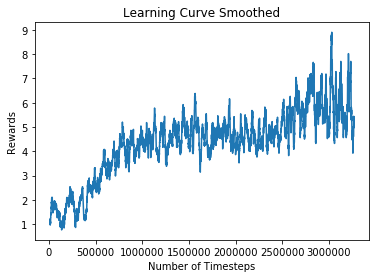

In [10]:
plot_results('./logs')

In [11]:
a = [1,2,3,4,5,6]

In [34]:
indx = 0
size_ratio = 0.5
last_ind = -2


In [39]:
a[-4::]

[3, 4, 5, 6]

In [32]:
a[2: -2][::-1]

[4, 3]

In [88]:
stop = 3
start = stop -min(1*7, len(a)) 

In [89]:
idxs = list(range(start,stop))

In [90]:
idxs

[-3, -2, -1, 0, 1, 2]

In [91]:
for idx in idxs: print(a[idx])

4
5
6
1
2
3


In [53]:
for i in range(10): print('sample', random.choice(list(range(2))+ list(range(0,6))))

sample 1
sample 1
sample 0
sample 0
sample 0
sample 1
sample 0
sample 1
sample 0
sample 1


In [18]:
for i in range(10):
    d.append(i)

In [19]:
d

deque([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
d.append(10)

In [21]:
d

deque([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [22]:
d.append(4)

In [23]:
d

deque([2, 3, 4, 5, 6, 7, 8, 9, 10, 4])

In [26]:
d = 5

AttributeError: attribute 'maxlen' of 'collections.deque' objects is not writable

In [29]:
import random
random.randran

TypeError: randint() takes 3 positional arguments but 5 were given

In [8]:
env = make_atari('BreakoutNoFrameskip-v4')
#env = wrap_atari_dqn(env)
env = Monitor(env, 'logs', allow_early_resets=True)

In [9]:
model = DQN(CnnPolicy, env, verbose=1)
model.learn(total_timesteps=250)

In [7]:
model = DQN.load("deepq_breakout_exp_lr")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [8]:
obs = env.reset()
i = 0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    i+=1
    env.render()